<a href="https://colab.research.google.com/github/Trading-com-Dados/desenvolvimento_interno/blob/main/20220526_Backtesting_a_mao_PMF_code_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://tradingcomdados.com/images/logotipo/logotipo-trading-com-dados.svg" width="300">

---
# **BACKTESTING  "*à mão*": o céu é o limite!** 
---
#### *Disclaimer:*
#### Este código foi elaborado para fins exclusivamente educacionais. O conteúdo aqui apresentado visa fornecer informações complementares para auxiliar o investidor na tomada de suas próprias decisões de investimento. Reforçando, nenhum tópico aqui abordado constitui qualquer tipo de indicação/oferta/solicitação de compra/venda de qualquer produto.
---



# **1. Bibliotecas utilizadas**

In [3]:
# Vamos utilizar a backtrader e a quantstats para conferir nossos backtests à mão

!pip install yfinance
!pip install ta
!pip install backtrader
!pip install quantstats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 6.4 MB 62.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel 

In [4]:
import numpy as np
import pandas as pd
from datetime import datetime
import pytz

import yfinance as yf
import ta
import backtrader as bt
import quantstats

import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# **2. Definir o setup e baixar os dados**

## 2.1. Cruzamento do preço na média móvel (**AGORA OPERAR COMPRA E VENDA**)

Vamos incluir a abertura de posição vendida, ou seja, venda para fechar a posição de compra, mas também para iniciar uma nova posição<p>

**Sinal de entrada: COMPRA**

Quando o preço cruzar a média móvel para cima: **COMPRA**<p>

1) Preço de fechamento do candle atual ficou acima da MM20p<p>
2) Preço de fechamento do candle anterior estava abaixo da MM20p<p>

**Sinal de entrada: VENDA**

Quando o preço cruzar a média móvel para baixo: **VENDA**<p>

1) Preço de fechamento do candle atual ficou abaixo da MM20p<p>
2) Preço de fechamento do candle anterior estava acima da MM20p<p>

**Sinal de saída (encerrar posição de COMPRA)**

Quando estiver comprado e o preço cruzar a média móvel para baixo: **VENDA**<p>

1) Preço de fechamento do candle atual ficou abaixo da MM20p<p>
2) Preço de fechamento do candle anterior estava acima da MM20p<p>

**Sinal de saída (encerrar posição de VENDA)**

Quando estiver vendido e o preço cruzar a média móvel para cima: **COMPRA**<p>

1) Preço de fechamento do candle atual ficou acima da MM20p<p>
2) Preço de fechamento do candle anterior estava abaixo da MM20p<p>

## 2.2. Importar dados com o Yahoo Finance

In [5]:
## Dados diários de Bitcoin para o ano de 2021 (criptomoedas são 7d/24h de negociações)

cotacoes_BTC_yf = yf.download("BTC-USD", start = '2021-01-01', end='2021-12-31', interval = "1d")
cotacoes_BTC_yf

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782
...,...,...,...,...,...,...
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299


## 2.3. Indicador MM e visualização do setup

In [6]:
## Cálculo Média Móvel de 20 períodos

cotacoes_BTC_yf['MMA20'] = cotacoes_BTC_yf['Close'].rolling(window=20).mean()
cotacoes_BTC_yf.head(20)

,Open,High,Low,Close,Adj Close,Volume,MMA20
Date,,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,NaN
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,NaN
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,NaN
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344,NaN
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,NaN
2021-01-06,34013.613281,36879.699219,33514.035156,36824.363281,36824.363281,75289433811,NaN
2021-01-07,36833.875000,40180.367188,36491.191406,39371.042969,39371.042969,84762141031,NaN
2021-01-08,39381.765625,41946.738281,36838.636719,40797.609375,40797.609375,88107519480,NaN
2021-01-09,40788.640625,41436.351562,38980.875000,40254.546875,40254.546875,61984162837,NaN


# **3. Localizar os sinais de entrada (candles sinalizadores) no dataframe**



## 3.1. Regras entrada compra

Regra 1) Preço de fechamento do candle atual ficou acima da MM20<p>
Regra 2) Preço de fechamento do candle anterior estava abaixo da MM20

In [7]:
cotacoes_BTC_yf['Buy_sign_R1'] = cotacoes_BTC_yf['Close'] > cotacoes_BTC_yf['MMA20']
cotacoes_BTC_yf.head(20)

,Open,High,Low,Close,Adj Close,Volume,MMA20,Buy_sign_R1
Date,,,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,NaN,False
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,NaN,False
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,NaN,False
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344,NaN,False
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,NaN,False
2021-01-06,34013.613281,36879.699219,33514.035156,36824.363281,36824.363281,75289433811,NaN,False
2021-01-07,36833.875000,40180.367188,36491.191406,39371.042969,39371.042969,84762141031,NaN,False
2021-01-08,39381.765625,41946.738281,36838.636719,40797.609375,40797.609375,88107519480,NaN,False
2021-01-09,40788.640625,41436.351562,38980.875000,40254.546875,40254.546875,61984162837,NaN,False


In [8]:
cotacoes_BTC_yf['Buy_sign_R2'] = cotacoes_BTC_yf['Close'].shift(1) < cotacoes_BTC_yf['MMA20'].shift(1)
cotacoes_BTC_yf.head(20)

,Open,High,Low,Close,Adj Close,Volume,MMA20,Buy_sign_R1,Buy_sign_R2
Date,,,,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,NaN,False,False
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,NaN,False,False
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,NaN,False,False
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344,NaN,False,False
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,NaN,False,False
2021-01-06,34013.613281,36879.699219,33514.035156,36824.363281,36824.363281,75289433811,NaN,False,False
2021-01-07,36833.875000,40180.367188,36491.191406,39371.042969,39371.042969,84762141031,NaN,False,False
2021-01-08,39381.765625,41946.738281,36838.636719,40797.609375,40797.609375,88107519480,NaN,False,False
2021-01-09,40788.640625,41436.351562,38980.875000,40254.546875,40254.546875,61984162837,NaN,False,False


In [9]:
cotacoes_BTC_yf['Buy_cand_sign'] = (cotacoes_BTC_yf['Buy_sign_R1']==True) & (cotacoes_BTC_yf['Buy_sign_R2']==True)
cotacoes_BTC_yf.head(20)

,Open,High,Low,Close,Adj Close,Volume,MMA20,Buy_sign_R1,Buy_sign_R2,Buy_cand_sign
Date,,,,,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,NaN,False,False,False
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,NaN,False,False,False
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,NaN,False,False,False
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344,NaN,False,False,False
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,NaN,False,False,False
2021-01-06,34013.613281,36879.699219,33514.035156,36824.363281,36824.363281,75289433811,NaN,False,False,False
2021-01-07,36833.875000,40180.367188,36491.191406,39371.042969,39371.042969,84762141031,NaN,False,False,False
2021-01-08,39381.765625,41946.738281,36838.636719,40797.609375,40797.609375,88107519480,NaN,False,False,False
2021-01-09,40788.640625,41436.351562,38980.875000,40254.546875,40254.546875,61984162837,NaN,False,False,False


In [10]:
candles_sinalizadores = cotacoes_BTC_yf[cotacoes_BTC_yf['Buy_cand_sign']==True]
print("Foram observados",len(candles_sinalizadores),"candles sinalizadores considerando o período analisado")
candles_sinalizadores.head()

Foram observados 22 candles sinalizadores considerando o período analisado


,Open,High,Low,Close,Adj Close,Volume,MMA20,Buy_sign_R1,Buy_sign_R2,Buy_cand_sign
Date,,,,,,,,,,
2021-02-02,33533.199219,35896.882812,33489.218750,35510.289062,35510.289062,63088585433,34200.042285,True,True,True
2021-03-03,48415.816406,52535.136719,48274.320312,50538.242188,50538.242188,53220811975,49993.718750,True,True,True
2021-03-07,48918.679688,51384.367188,48918.679688,51206.691406,51206.691406,43137459378,50310.460352,True,True,True
2021-03-29,55947.898438,58342.097656,55139.339844,57750.199219,57750.199219,57625587027,56693.754297,True,True,True
2021-04-08,56099.914062,58338.738281,55879.085938,58323.953125,58323.953125,53053855641,56934.878516,True,True,True


## 3.2. Regras entrada venda

Regra 1) Preço de fechamento do candle atual ficou abaixo da MM20<p>
Regra 2) Preço de fechamento do candle anterior estava acima da MM20

In [11]:
cotacoes_BTC_yf['Sell_sign_R1'] = cotacoes_BTC_yf['Close'] < cotacoes_BTC_yf['MMA20']
cotacoes_BTC_yf.head(20)

,Open,High,Low,Close,Adj Close,Volume,MMA20,Buy_sign_R1,Buy_sign_R2,Buy_cand_sign,Sell_sign_R1
Date,,,,,,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,NaN,False,False,False,False
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,NaN,False,False,False,False
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,NaN,False,False,False,False
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344,NaN,False,False,False,False
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,NaN,False,False,False,False
2021-01-06,34013.613281,36879.699219,33514.035156,36824.363281,36824.363281,75289433811,NaN,False,False,False,False
2021-01-07,36833.875000,40180.367188,36491.191406,39371.042969,39371.042969,84762141031,NaN,False,False,False,False
2021-01-08,39381.765625,41946.738281,36838.636719,40797.609375,40797.609375,88107519480,NaN,False,False,False,False
2021-01-09,40788.640625,41436.351562,38980.875000,40254.546875,40254.546875,61984162837,NaN,False,False,False,False


In [12]:
cotacoes_BTC_yf['Sell_sign_R2'] = cotacoes_BTC_yf['Close'].shift(1) > cotacoes_BTC_yf['MMA20'].shift(1)
cotacoes_BTC_yf.head(20)

,Open,High,Low,Close,Adj Close,Volume,MMA20,Buy_sign_R1,Buy_sign_R2,Buy_cand_sign,Sell_sign_R1,Sell_sign_R2
Date,,,,,,,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,NaN,False,False,False,False,False
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,NaN,False,False,False,False,False
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,NaN,False,False,False,False,False
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344,NaN,False,False,False,False,False
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,NaN,False,False,False,False,False
2021-01-06,34013.613281,36879.699219,33514.035156,36824.363281,36824.363281,75289433811,NaN,False,False,False,False,False
2021-01-07,36833.875000,40180.367188,36491.191406,39371.042969,39371.042969,84762141031,NaN,False,False,False,False,False
2021-01-08,39381.765625,41946.738281,36838.636719,40797.609375,40797.609375,88107519480,NaN,False,False,False,False,False
2021-01-09,40788.640625,41436.351562,38980.875000,40254.546875,40254.546875,61984162837,NaN,False,False,False,False,False


In [15]:
cotacoes_BTC_yf['Sell_cand_sign'] = (cotacoes_BTC_yf['Sell_sign_R1']==True) & (cotacoes_BTC_yf['Sell_sign_R2']==True)
cotacoes_BTC_yf.head(20)

,Open,High,Low,Close,Adj Close,Volume,MMA20,Buy_sign_R1,Buy_sign_R2,Buy_cand_sign,Sell_sign_R1,Sell_sign_R2,Sell_cand_sign
Date,,,,,,,,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,NaN,False,False,False,False,False,False
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,NaN,False,False,False,False,False,False
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,NaN,False,False,False,False,False,False
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344,NaN,False,False,False,False,False,False
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,NaN,False,False,False,False,False,False
2021-01-06,34013.613281,36879.699219,33514.035156,36824.363281,36824.363281,75289433811,NaN,False,False,False,False,False,False
2021-01-07,36833.875000,40180.367188,36491.191406,39371.042969,39371.042969,84762141031,NaN,False,False,False,False,False,False
2021-01-08,39381.765625,41946.738281,36838.636719,40797.609375,40797.609375,88107519480,NaN,False,False,False,False,False,False
2021-01-09,40788.640625,41436.351562,38980.875000,40254.546875,40254.546875,61984162837,NaN,False,False,False,False,False,False


In [16]:
candles_sinalizadores = cotacoes_BTC_yf[cotacoes_BTC_yf['Sell_cand_sign']==True]
print("Foram observados",len(candles_sinalizadores),"candles sinalizadores considerando o período analisado")
candles_sinalizadores.head()

Foram observados 22 candles sinalizadores considerando o período analisado


,Open,High,Low,Close,Adj Close,Volume,MMA20,Buy_sign_R1,Buy_sign_R2,Buy_cand_sign,Sell_sign_R1,Sell_sign_R2,Sell_cand_sign
Date,,,,,,,,,,,,,
2021-02-25,49709.082031,51948.968750,47093.851562,47093.851562,47093.851562,54506565949,48866.722852,False,False,False,True,True,True
2021-03-04,50522.304688,51735.089844,47656.929688,48561.167969,48561.167969,52343816680,50046.534570,False,False,False,True,True,True
2021-03-22,57517.890625,58471.480469,54288.156250,54529.144531,54529.144531,56521454974,55253.118750,False,False,False,True,True,True
2021-04-07,58186.507812,58731.144531,55604.023438,56048.937500,56048.937500,75645303584,56936.013477,False,False,False,True,True,True
2021-04-18,60701.886719,61057.457031,52829.535156,56216.183594,56216.183594,97468872758,59541.941602,False,False,False,True,True,True


# **4. Registrar os preços de compra (Buy at Market)**

## 4.1. Ordens de compra a mercado

Nesse caso, abriremos nossa posição na abertura do próximo candle, ou seja, assim q confirmamos o candle sinalizador

In [17]:
cotacoes_BTC_yf['Buy_market'] = cotacoes_BTC_yf['Open'].shift(-1)
cotacoes_BTC_yf

,Open,High,Low,Close,Adj Close,Volume,MMA20,Buy_sign_R1,Buy_sign_R2,Buy_cand_sign,Sell_sign_R1,Sell_sign_R2,Sell_cand_sign,Buy_market
Date,,,,,,,,,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,NaN,False,False,False,False,False,False,29376.455078
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,NaN,False,False,False,False,False,False,32129.408203
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,NaN,False,False,False,False,False,False,32810.949219
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344,NaN,False,False,False,False,False,False,31977.041016
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,NaN,False,False,False,False,False,False,34013.613281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,48624.159766,True,False,False,False,True,False,50679.859375
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,48478.362695,False,False,False,True,True,True,47623.871094
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,48416.992188,False,True,False,True,False,False,46490.605469


## 4.2. Ordens de venda a mercado

In [18]:
cotacoes_BTC_yf['Sell_market'] = cotacoes_BTC_yf['Open'].shift(-1)
cotacoes_BTC_yf

,Open,High,Low,Close,Adj Close,Volume,MMA20,Buy_sign_R1,Buy_sign_R2,Buy_cand_sign,Sell_sign_R1,Sell_sign_R2,Sell_cand_sign,Buy_market,Sell_market
Date,,,,,,,,,,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,NaN,False,False,False,False,False,False,29376.455078,29376.455078
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,NaN,False,False,False,False,False,False,32129.408203,32129.408203
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,NaN,False,False,False,False,False,False,32810.949219,32810.949219
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344,NaN,False,False,False,False,False,False,31977.041016,31977.041016
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,NaN,False,False,False,False,False,False,34013.613281,34013.613281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,48624.159766,True,False,False,False,True,False,50679.859375,50679.859375
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,48478.362695,False,False,False,True,True,True,47623.871094,47623.871094
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,48416.992188,False,True,False,True,False,False,46490.605469,46490.605469


# **5. Determinar o sinal de saída e registrar o preço**

## 5.1. Saída da compra anteriormente executada

In [19]:
cotacoes_BTC_yf['Sell_close_position_R1'] = cotacoes_BTC_yf['Close'] < cotacoes_BTC_yf['MMA20']
cotacoes_BTC_yf

,Open,High,Low,Close,Adj Close,Volume,MMA20,Buy_sign_R1,Buy_sign_R2,Buy_cand_sign,Sell_sign_R1,Sell_sign_R2,Sell_cand_sign,Buy_market,Sell_market,Sell_close_position_R1
Date,,,,,,,,,,,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,NaN,False,False,False,False,False,False,29376.455078,29376.455078,False
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,NaN,False,False,False,False,False,False,32129.408203,32129.408203,False
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,NaN,False,False,False,False,False,False,32810.949219,32810.949219,False
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344,NaN,False,False,False,False,False,False,31977.041016,31977.041016,False
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,NaN,False,False,False,False,False,False,34013.613281,34013.613281,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,48624.159766,True,False,False,False,True,False,50679.859375,50679.859375,False
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,48478.362695,False,False,False,True,True,True,47623.871094,47623.871094,True
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,48416.992188,False,True,False,True,False,False,46490.605469,46490.605469,True


In [20]:
cotacoes_BTC_yf['Sell_close_position_R2'] = cotacoes_BTC_yf['Close'].shift(1) > cotacoes_BTC_yf['MMA20'].shift(1)
cotacoes_BTC_yf

,Open,High,Low,Close,Adj Close,Volume,MMA20,Buy_sign_R1,Buy_sign_R2,Buy_cand_sign,Sell_sign_R1,Sell_sign_R2,Sell_cand_sign,Buy_market,Sell_market,Sell_close_position_R1,Sell_close_position_R2
Date,,,,,,,,,,,,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,NaN,False,False,False,False,False,False,29376.455078,29376.455078,False,False
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,NaN,False,False,False,False,False,False,32129.408203,32129.408203,False,False
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,NaN,False,False,False,False,False,False,32810.949219,32810.949219,False,False
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344,NaN,False,False,False,False,False,False,31977.041016,31977.041016,False,False
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,NaN,False,False,False,False,False,False,34013.613281,34013.613281,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,48624.159766,True,False,False,False,True,False,50679.859375,50679.859375,False,True
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,48478.362695,False,False,False,True,True,True,47623.871094,47623.871094,True,True
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,48416.992188,False,True,False,True,False,False,46490.605469,46490.605469,True,False


In [21]:
cotacoes_BTC_yf['Sell_close_position_FINAL'] = (cotacoes_BTC_yf.Sell_close_position_R1==True) & (cotacoes_BTC_yf.Sell_close_position_R2==True)
cotacoes_BTC_yf

,Open,High,Low,Close,Adj Close,Volume,MMA20,Buy_sign_R1,Buy_sign_R2,Buy_cand_sign,Sell_sign_R1,Sell_sign_R2,Sell_cand_sign,Buy_market,Sell_market,Sell_close_position_R1,Sell_close_position_R2,Sell_close_position_FINAL
Date,,,,,,,,,,,,,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,NaN,False,False,False,False,False,False,29376.455078,29376.455078,False,False,False
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,NaN,False,False,False,False,False,False,32129.408203,32129.408203,False,False,False
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,NaN,False,False,False,False,False,False,32810.949219,32810.949219,False,False,False
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344,NaN,False,False,False,False,False,False,31977.041016,31977.041016,False,False,False
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,NaN,False,False,False,False,False,False,34013.613281,34013.613281,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,48624.159766,True,False,False,False,True,False,50679.859375,50679.859375,False,True,False
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,48478.362695,False,False,False,True,True,True,47623.871094,47623.871094,True,True,True
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,48416.992188,False,True,False,True,False,False,46490.605469,46490.605469,True,False,False


In [22]:
cotacoes_BTC_yf['Sell_market_close_position'] = cotacoes_BTC_yf['Open'].shift(-1)
cotacoes_BTC_yf

,Open,High,Low,Close,Adj Close,Volume,MMA20,Buy_sign_R1,Buy_sign_R2,Buy_cand_sign,Sell_sign_R1,Sell_sign_R2,Sell_cand_sign,Buy_market,Sell_market,Sell_close_position_R1,Sell_close_position_R2,Sell_close_position_FINAL,Sell_market_close_position
Date,,,,,,,,,,,,,,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,NaN,False,False,False,False,False,False,29376.455078,29376.455078,False,False,False,29376.455078
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,NaN,False,False,False,False,False,False,32129.408203,32129.408203,False,False,False,32129.408203
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,NaN,False,False,False,False,False,False,32810.949219,32810.949219,False,False,False,32810.949219
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344,NaN,False,False,False,False,False,False,31977.041016,31977.041016,False,False,False,31977.041016
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,NaN,False,False,False,False,False,False,34013.613281,34013.613281,False,False,False,34013.613281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,48624.159766,True,False,False,False,True,False,50679.859375,50679.859375,False,True,False,50679.859375
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,48478.362695,False,False,False,True,True,True,47623.871094,47623.871094,True,True,True,47623.871094
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,48416.992188,False,True,False,True,False,False,46490.605469,46490.605469,True,False,False,46490.605469


## 5.2. Saída da venda anteriormente executada

In [23]:
cotacoes_BTC_yf['Buy_close_position_R1'] = cotacoes_BTC_yf['Close'] > cotacoes_BTC_yf['MMA20']
cotacoes_BTC_yf

,Open,High,Low,Close,Adj Close,Volume,MMA20,Buy_sign_R1,Buy_sign_R2,Buy_cand_sign,Sell_sign_R1,Sell_sign_R2,Sell_cand_sign,Buy_market,Sell_market,Sell_close_position_R1,Sell_close_position_R2,Sell_close_position_FINAL,Sell_market_close_position,Buy_close_position_R1
Date,,,,,,,,,,,,,,,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,NaN,False,False,False,False,False,False,29376.455078,29376.455078,False,False,False,29376.455078,False
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,NaN,False,False,False,False,False,False,32129.408203,32129.408203,False,False,False,32129.408203,False
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,NaN,False,False,False,False,False,False,32810.949219,32810.949219,False,False,False,32810.949219,False
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344,NaN,False,False,False,False,False,False,31977.041016,31977.041016,False,False,False,31977.041016,False
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,NaN,False,False,False,False,False,False,34013.613281,34013.613281,False,False,False,34013.613281,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,48624.159766,True,False,False,False,True,False,50679.859375,50679.859375,False,True,False,50679.859375,True
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,48478.362695,False,False,False,True,True,True,47623.871094,47623.871094,True,True,True,47623.871094,False
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,48416.992188,False,True,False,True,False,False,46490.605469,46490.605469,True,False,False,46490.605469,False


In [24]:
cotacoes_BTC_yf['Buy_close_position_R2'] = cotacoes_BTC_yf['Close'].shift(1) < cotacoes_BTC_yf['MMA20'].shift(1)
cotacoes_BTC_yf

,Open,High,Low,Close,Adj Close,Volume,MMA20,Buy_sign_R1,Buy_sign_R2,Buy_cand_sign,...,Sell_sign_R2,Sell_cand_sign,Buy_market,Sell_market,Sell_close_position_R1,Sell_close_position_R2,Sell_close_position_FINAL,Sell_market_close_position,Buy_close_position_R1,Buy_close_position_R2
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,NaN,False,False,False,...,False,False,29376.455078,29376.455078,False,False,False,29376.455078,False,False
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,NaN,False,False,False,...,False,False,32129.408203,32129.408203,False,False,False,32129.408203,False,False
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,NaN,False,False,False,...,False,False,32810.949219,32810.949219,False,False,False,32810.949219,False,False
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344,NaN,False,False,False,...,False,False,31977.041016,31977.041016,False,False,False,31977.041016,False,False
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,NaN,False,False,False,...,False,False,34013.613281,34013.613281,False,False,False,34013.613281,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,48624.159766,True,False,False,...,True,False,50679.859375,50679.859375,False,True,False,50679.859375,True,False
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,48478.362695,False,False,False,...,True,True,47623.871094,47623.871094,True,True,True,47623.871094,False,False
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,48416.992188,False,True,False,...,False,False,46490.605469,46490.605469,True,False,False,46490.605469,False,True


In [25]:
cotacoes_BTC_yf['Buy_close_position_FINAL'] = (cotacoes_BTC_yf.Buy_close_position_R1==True) & (cotacoes_BTC_yf.Buy_close_position_R2==True)
cotacoes_BTC_yf

,Open,High,Low,Close,Adj Close,Volume,MMA20,Buy_sign_R1,Buy_sign_R2,Buy_cand_sign,...,Sell_cand_sign,Buy_market,Sell_market,Sell_close_position_R1,Sell_close_position_R2,Sell_close_position_FINAL,Sell_market_close_position,Buy_close_position_R1,Buy_close_position_R2,Buy_close_position_FINAL
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,NaN,False,False,False,...,False,29376.455078,29376.455078,False,False,False,29376.455078,False,False,False
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,NaN,False,False,False,...,False,32129.408203,32129.408203,False,False,False,32129.408203,False,False,False
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,NaN,False,False,False,...,False,32810.949219,32810.949219,False,False,False,32810.949219,False,False,False
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344,NaN,False,False,False,...,False,31977.041016,31977.041016,False,False,False,31977.041016,False,False,False
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,NaN,False,False,False,...,False,34013.613281,34013.613281,False,False,False,34013.613281,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,48624.159766,True,False,False,...,False,50679.859375,50679.859375,False,True,False,50679.859375,True,False,False
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,48478.362695,False,False,False,...,True,47623.871094,47623.871094,True,True,True,47623.871094,False,False,False
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,48416.992188,False,True,False,...,False,46490.605469,46490.605469,True,False,False,46490.605469,False,True,False


In [26]:
cotacoes_BTC_yf['Buy_market_close_position'] = cotacoes_BTC_yf['Open'].shift(-1)
cotacoes_BTC_yf

,Open,High,Low,Close,Adj Close,Volume,MMA20,Buy_sign_R1,Buy_sign_R2,Buy_cand_sign,...,Buy_market,Sell_market,Sell_close_position_R1,Sell_close_position_R2,Sell_close_position_FINAL,Sell_market_close_position,Buy_close_position_R1,Buy_close_position_R2,Buy_close_position_FINAL,Buy_market_close_position
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,NaN,False,False,False,...,29376.455078,29376.455078,False,False,False,29376.455078,False,False,False,29376.455078
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,NaN,False,False,False,...,32129.408203,32129.408203,False,False,False,32129.408203,False,False,False,32129.408203
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,NaN,False,False,False,...,32810.949219,32810.949219,False,False,False,32810.949219,False,False,False,32810.949219
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344,NaN,False,False,False,...,31977.041016,31977.041016,False,False,False,31977.041016,False,False,False,31977.041016
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,NaN,False,False,False,...,34013.613281,34013.613281,False,False,False,34013.613281,False,False,False,34013.613281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,48624.159766,True,False,False,...,50679.859375,50679.859375,False,True,False,50679.859375,True,False,False,50679.859375
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,48478.362695,False,False,False,...,47623.871094,47623.871094,True,True,True,47623.871094,False,False,False,47623.871094
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,48416.992188,False,True,False,...,46490.605469,46490.605469,True,False,False,46490.605469,False,True,False,46490.605469


# **6. Organizar os preços de entrada (compra) e saída (venda)**

## 6.1. Preços de entrada compra/venda

In [27]:
cotacoes_BTC_yf.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'MMA20',
       'Buy_sign_R1', 'Buy_sign_R2', 'Buy_cand_sign', 'Sell_sign_R1',
       'Sell_sign_R2', 'Sell_cand_sign', 'Buy_market', 'Sell_market',
       'Sell_close_position_R1', 'Sell_close_position_R2',
       'Sell_close_position_FINAL', 'Sell_market_close_position',
       'Buy_close_position_R1', 'Buy_close_position_R2',
       'Buy_close_position_FINAL', 'Buy_market_close_position'],
      dtype='object')

In [28]:
print('Tivemos',len(cotacoes_BTC_yf[cotacoes_BTC_yf.Buy_cand_sign==True]),'entradas de compra')
cotacoes_BTC_yf[cotacoes_BTC_yf.Buy_cand_sign==True].head()

Tivemos 22 entradas de compra


,Open,High,Low,Close,Adj Close,Volume,MMA20,Buy_sign_R1,Buy_sign_R2,Buy_cand_sign,...,Buy_market,Sell_market,Sell_close_position_R1,Sell_close_position_R2,Sell_close_position_FINAL,Sell_market_close_position,Buy_close_position_R1,Buy_close_position_R2,Buy_close_position_FINAL,Buy_market_close_position
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-02,33533.199219,35896.882812,33489.218750,35510.289062,35510.289062,63088585433,34200.042285,True,True,True,...,35510.820312,35510.820312,False,False,False,35510.820312,True,True,True,35510.820312
2021-03-03,48415.816406,52535.136719,48274.320312,50538.242188,50538.242188,53220811975,49993.718750,True,True,True,...,50522.304688,50522.304688,False,False,False,50522.304688,True,True,True,50522.304688
2021-03-07,48918.679688,51384.367188,48918.679688,51206.691406,51206.691406,43137459378,50310.460352,True,True,True,...,51174.117188,51174.117188,False,False,False,51174.117188,True,True,True,51174.117188
2021-03-29,55947.898438,58342.097656,55139.339844,57750.199219,57750.199219,57625587027,56693.754297,True,True,True,...,57750.132812,57750.132812,False,False,False,57750.132812,True,True,True,57750.132812
2021-04-08,56099.914062,58338.738281,55879.085938,58323.953125,58323.953125,53053855641,56934.878516,True,True,True,...,58326.562500,58326.562500,False,False,False,58326.562500,True,True,True,58326.562500


In [29]:
# Registrar os preços de entrada de compra

precos_compras = cotacoes_BTC_yf[cotacoes_BTC_yf.Buy_cand_sign==True]['Buy_market']
precos_compras

Date
2021-02-02    35510.820312
2021-03-03    50522.304688
2021-03-07    51174.117188
2021-03-29    57750.132812
2021-04-08    58326.562500
2021-04-30    57714.664062
2021-05-05    57441.308594
2021-06-03    39242.484375
2021-06-09    37389.515625
2021-06-13    39016.968750
2021-06-29    35908.386719
2021-07-04    35284.343750
2021-07-11    34254.015625
2021-07-23    33593.730469
2021-09-01    48807.847656
2021-09-15    48158.906250
2021-09-18    48268.855469
2021-10-01    48137.468750
2021-10-28    60624.871094
2021-11-02    63254.335938
2021-11-07    63344.066406
2021-12-22    48626.343750
Name: Buy_market, dtype: float64

In [30]:
print('Tivemos',len(cotacoes_BTC_yf[cotacoes_BTC_yf.Sell_cand_sign==True]),'entradas de venda')
cotacoes_BTC_yf[cotacoes_BTC_yf.Sell_cand_sign==True].head()

Tivemos 22 entradas de venda


,Open,High,Low,Close,Adj Close,Volume,MMA20,Buy_sign_R1,Buy_sign_R2,Buy_cand_sign,...,Buy_market,Sell_market,Sell_close_position_R1,Sell_close_position_R2,Sell_close_position_FINAL,Sell_market_close_position,Buy_close_position_R1,Buy_close_position_R2,Buy_close_position_FINAL,Buy_market_close_position
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-25,49709.082031,51948.968750,47093.851562,47093.851562,47093.851562,54506565949,48866.722852,False,False,False,...,47180.464844,47180.464844,True,True,True,47180.464844,False,False,False,47180.464844
2021-03-04,50522.304688,51735.089844,47656.929688,48561.167969,48561.167969,52343816680,50046.534570,False,False,False,...,48527.031250,48527.031250,True,True,True,48527.031250,False,False,False,48527.031250
2021-03-22,57517.890625,58471.480469,54288.156250,54529.144531,54529.144531,56521454974,55253.118750,False,False,False,...,54511.660156,54511.660156,True,True,True,54511.660156,False,False,False,54511.660156
2021-04-07,58186.507812,58731.144531,55604.023438,56048.937500,56048.937500,75645303584,56936.013477,False,False,False,...,56099.914062,56099.914062,True,True,True,56099.914062,False,False,False,56099.914062
2021-04-18,60701.886719,61057.457031,52829.535156,56216.183594,56216.183594,97468872758,59541.941602,False,False,False,...,56191.585938,56191.585938,True,True,True,56191.585938,False,False,False,56191.585938


In [31]:
# Registrar os preços de entrada de venda

precos_vendas = cotacoes_BTC_yf[cotacoes_BTC_yf.Sell_cand_sign==True]['Sell_market']
precos_vendas

Date
2021-02-25    47180.464844
2021-03-04    48527.031250
2021-03-22    54511.660156
2021-04-07    56099.914062
2021-04-18    56191.585938
2021-05-04    53252.164062
2021-05-12    49735.433594
2021-06-04    36880.156250
2021-06-12    35555.789062
2021-06-18    35854.527344
2021-06-30    35035.984375
2021-07-05    33723.507812
2021-07-12    33125.468750
2021-08-30    47024.339844
2021-09-07    46827.761719
2021-09-16    47771.003906
2021-09-19    47261.406250
2021-10-27    58470.730469
2021-11-01    60963.253906
2021-11-04    61460.078125
2021-11-16    60139.621094
2021-12-28    47623.871094
Name: Sell_market, dtype: float64

## 6.2. Preços de saída compra/venda

In [32]:
# Aqui importante notar se o número de saídas de compra é o mesmo que de entradas de compra

print('Tivemos',len(cotacoes_BTC_yf[cotacoes_BTC_yf.Sell_close_position_FINAL]),'saídas de compra')

Tivemos 22 saídas de compra


In [33]:
# Registrar os preços de saídas de compra

precos_saida_compra = cotacoes_BTC_yf[cotacoes_BTC_yf.Sell_close_position_FINAL==True]['Sell_market_close_position']
precos_saida_compra

Date
2021-02-25    47180.464844
2021-03-04    48527.031250
2021-03-22    54511.660156
2021-04-07    56099.914062
2021-04-18    56191.585938
2021-05-04    53252.164062
2021-05-12    49735.433594
2021-06-04    36880.156250
2021-06-12    35555.789062
2021-06-18    35854.527344
2021-06-30    35035.984375
2021-07-05    33723.507812
2021-07-12    33125.468750
2021-08-30    47024.339844
2021-09-07    46827.761719
2021-09-16    47771.003906
2021-09-19    47261.406250
2021-10-27    58470.730469
2021-11-01    60963.253906
2021-11-04    61460.078125
2021-11-16    60139.621094
2021-12-28    47623.871094
Name: Sell_market_close_position, dtype: float64

In [34]:
print('Tivemos',len(cotacoes_BTC_yf[cotacoes_BTC_yf.Buy_close_position_FINAL]),'saídas de venda')

Tivemos 22 saídas de venda


In [35]:
# Registrar os preços de saídas de venda

precos_saida_venda = cotacoes_BTC_yf[cotacoes_BTC_yf.Buy_close_position_FINAL==True]['Buy_market_close_position']
precos_saida_venda

Date
2021-02-02    35510.820312
2021-03-03    50522.304688
2021-03-07    51174.117188
2021-03-29    57750.132812
2021-04-08    58326.562500
2021-04-30    57714.664062
2021-05-05    57441.308594
2021-06-03    39242.484375
2021-06-09    37389.515625
2021-06-13    39016.968750
2021-06-29    35908.386719
2021-07-04    35284.343750
2021-07-11    34254.015625
2021-07-23    33593.730469
2021-09-01    48807.847656
2021-09-15    48158.906250
2021-09-18    48268.855469
2021-10-01    48137.468750
2021-10-28    60624.871094
2021-11-02    63254.335938
2021-11-07    63344.066406
2021-12-22    48626.343750
Name: Buy_market_close_position, dtype: float64

In [36]:
# Agora podemos visualizar todas as entradas e saídas de forma clara

all_trades_ponta_compradora = pd.concat([precos_compras,precos_saida_compra],axis=1)
all_trades_ponta_compradora

,Buy_market,Sell_market_close_position
Date,,
2021-02-02,35510.820312,NaN
2021-02-25,NaN,47180.464844
2021-03-03,50522.304688,NaN
2021-03-04,NaN,48527.031250
2021-03-07,51174.117188,NaN
2021-03-22,NaN,54511.660156
2021-03-29,57750.132812,NaN
2021-04-07,NaN,56099.914062
2021-04-08,58326.562500,NaN


Aqui notamos uma questão importante ao fazer o backtesting manual<p>
Veja que temos uma primeira operação de saída de venda, no dia 02/02/2021.<p>
Entretanto eu só saio quando eu entrei previamente. Nesse caso vamos excluir a primeira linha

In [37]:
# Agora podemos visualizar todas as entradas e saídas de forma clara
# Veja a falha de sair de uma operação sem ter entrado (02/02/2021)

all_trades_ponta_vendedora = pd.concat([precos_vendas,precos_saida_venda],axis=1)
all_trades_ponta_vendedora

,Sell_market,Buy_market_close_position
Date,,
2021-02-02,NaN,35510.820312
2021-02-25,47180.464844,NaN
2021-03-03,NaN,50522.304688
2021-03-04,48527.031250,NaN
2021-03-07,NaN,51174.117188
2021-03-22,54511.660156,NaN
2021-03-29,NaN,57750.132812
2021-04-07,56099.914062,NaN
2021-04-08,NaN,58326.562500


In [66]:
# Agora concatenando para corrigir o problema

all_trades_ponta_vendedora = pd.concat([precos_vendas,precos_saida_venda[1:]],axis=1)
all_trades_ponta_vendedora

,Sell_market,Buy_market_close_position
Date,,
2021-02-25,47180.464844,NaN
2021-03-03,NaN,50522.304688
2021-03-04,48527.031250,NaN
2021-03-07,NaN,51174.117188
2021-03-22,54511.660156,NaN
2021-03-29,NaN,57750.132812
2021-04-07,56099.914062,NaN
2021-04-08,NaN,58326.562500
2021-04-18,56191.585938,NaN


Se olharmos o dataframe acima vemos um último problema, relacionado à última linha <p>
Nesse caso, observamos que houve uma entrada de venda no dia 28/12/2021 mas que não apresenta a sua saída respectiva<p>
Isso indicaria que ainda estamos posicionados. O mais simples a se fazer é excluir a última entrada<p>

In [67]:
# Excluir a última linha para não terminar o backtesting posicionado

all_trades_ponta_vendedora = pd.concat([precos_vendas[:-1],precos_saida_venda[1:]],axis=1)
all_trades_ponta_vendedora

,Sell_market,Buy_market_close_position
Date,,
2021-02-25,47180.464844,NaN
2021-03-03,NaN,50522.304688
2021-03-04,48527.031250,NaN
2021-03-07,NaN,51174.117188
2021-03-22,54511.660156,NaN
2021-03-29,NaN,57750.132812
2021-04-07,56099.914062,NaN
2021-04-08,NaN,58326.562500
2021-04-18,56191.585938,NaN


# **7. Calcular algumas métricas bem simples de backtesting**

## **7.1. Resultado líquido**

In [68]:
ponta_compradora = pd.DataFrame(zip(precos_compras,precos_saida_compra),columns=['Entrada_Compra','Saida_Compra'])
ponta_compradora

,Entrada_Compra,Saida_Compra
0,35510.820312,47180.464844
1,50522.304688,48527.031250
2,51174.117188,54511.660156
3,57750.132812,56099.914062
4,58326.562500,56191.585938
5,57714.664062,53252.164062
6,57441.308594,49735.433594
7,39242.484375,36880.156250
8,37389.515625,35555.789062
9,39016.968750,35854.527344


In [69]:
# Calcular o resultado nominal e percentual das negociações

ponta_compradora['Resultado'] = ponta_compradora['Saida_Compra'] - ponta_compradora['Entrada_Compra']
ponta_compradora['Resultado_%'] = (ponta_compradora['Saida_Compra'] - ponta_compradora['Entrada_Compra'])/ponta_compradora['Entrada_Compra']
ponta_compradora['Operação'] = 'Compra'
ponta_compradora

,Entrada_Compra,Saida_Compra,Resultado,Resultado_%,Operação
0,35510.820312,47180.464844,11669.644531,0.328622,Compra
1,50522.304688,48527.031250,-1995.273438,-0.039493,Compra
2,51174.117188,54511.660156,3337.542969,0.065219,Compra
3,57750.132812,56099.914062,-1650.218750,-0.028575,Compra
4,58326.562500,56191.585938,-2134.976562,-0.036604,Compra
5,57714.664062,53252.164062,-4462.500000,-0.077320,Compra
6,57441.308594,49735.433594,-7705.875000,-0.134152,Compra
7,39242.484375,36880.156250,-2362.328125,-0.060198,Compra
8,37389.515625,35555.789062,-1833.726562,-0.049044,Compra
9,39016.968750,35854.527344,-3162.441406,-0.081053,Compra


In [70]:
ponta_vendedora = pd.DataFrame(zip(precos_vendas[:-1],precos_saida_venda[1:]),columns=['Entrada_Venda','Saida_Venda'])
ponta_vendedora

,Entrada_Venda,Saida_Venda
0,47180.464844,50522.304688
1,48527.031250,51174.117188
2,54511.660156,57750.132812
3,56099.914062,58326.562500
4,56191.585938,57714.664062
5,53252.164062,57441.308594
6,49735.433594,39242.484375
7,36880.156250,37389.515625
8,35555.789062,39016.968750
9,35854.527344,35908.386719


In [71]:
# Calcular o resultado nominal e percentual das negociações

ponta_vendedora['Resultado'] = ponta_vendedora['Saida_Venda'] - ponta_vendedora['Entrada_Venda']
ponta_vendedora['Resultado_%'] = (ponta_vendedora['Saida_Venda'] - ponta_vendedora['Entrada_Venda'])/ponta_vendedora['Entrada_Venda']
ponta_vendedora['Operação'] = 'Venda'
ponta_vendedora

,Entrada_Venda,Saida_Venda,Resultado,Resultado_%,Operação
0,47180.464844,50522.304688,3341.839844,0.070831,Venda
1,48527.031250,51174.117188,2647.085938,0.054549,Venda
2,54511.660156,57750.132812,3238.472656,0.059409,Venda
3,56099.914062,58326.562500,2226.648438,0.039691,Venda
4,56191.585938,57714.664062,1523.078125,0.027105,Venda
5,53252.164062,57441.308594,4189.144531,0.078666,Venda
6,49735.433594,39242.484375,-10492.949219,-0.210975,Venda
7,36880.156250,37389.515625,509.359375,0.013811,Venda
8,35555.789062,39016.968750,3461.179688,0.097345,Venda
9,35854.527344,35908.386719,53.859375,0.001502,Venda


In [72]:
all_trades_FINAL = pd.concat([ponta_compradora,ponta_vendedora],axis=1)
all_trades_FINAL

,Entrada_Compra,Saida_Compra,Resultado,Resultado_%,Operação,Entrada_Venda,Saida_Venda,Resultado,Resultado_%,Operação
0,35510.820312,47180.464844,11669.644531,0.328622,Compra,47180.464844,50522.304688,3341.839844,0.070831,Venda
1,50522.304688,48527.031250,-1995.273438,-0.039493,Compra,48527.031250,51174.117188,2647.085938,0.054549,Venda
2,51174.117188,54511.660156,3337.542969,0.065219,Compra,54511.660156,57750.132812,3238.472656,0.059409,Venda
3,57750.132812,56099.914062,-1650.218750,-0.028575,Compra,56099.914062,58326.562500,2226.648438,0.039691,Venda
4,58326.562500,56191.585938,-2134.976562,-0.036604,Compra,56191.585938,57714.664062,1523.078125,0.027105,Venda
5,57714.664062,53252.164062,-4462.500000,-0.077320,Compra,53252.164062,57441.308594,4189.144531,0.078666,Venda
6,57441.308594,49735.433594,-7705.875000,-0.134152,Compra,49735.433594,39242.484375,-10492.949219,-0.210975,Venda
7,39242.484375,36880.156250,-2362.328125,-0.060198,Compra,36880.156250,37389.515625,509.359375,0.013811,Venda
8,37389.515625,35555.789062,-1833.726562,-0.049044,Compra,35555.789062,39016.968750,3461.179688,0.097345,Venda
9,39016.968750,35854.527344,-3162.441406,-0.081053,Compra,35854.527344,35908.386719,53.859375,0.001502,Venda


In [73]:
# Filtro dos candles sinalizadores para última visualização dos trades

cotacoes_BTC_yf[(cotacoes_BTC_yf.Buy_cand_sign==True) | (cotacoes_BTC_yf.Sell_cand_sign==True)].transpose()

Date,2021-02-02,2021-02-25,2021-03-03,2021-03-04,2021-03-07,2021-03-22,2021-03-29,2021-04-07,2021-04-08,2021-04-18,...,2021-10-01,2021-10-27,2021-10-28,2021-11-01,2021-11-02,2021-11-04,2021-11-07,2021-11-16,2021-12-22,2021-12-28
Open,33533.199219,49709.082031,48415.816406,50522.304688,48918.679688,57517.890625,55947.898438,58186.507812,56099.914062,60701.886719,...,43816.742188,60352.0,58470.730469,61320.449219,60963.253906,62941.804688,61554.921875,63721.195312,48937.097656,50679.859375
High,35896.882812,51948.96875,52535.136719,51735.089844,51384.367188,58471.480469,58342.097656,58731.144531,58338.738281,61057.457031,...,48436.011719,61435.183594,62128.632812,62419.003906,64242.792969,63123.289062,63326.988281,63721.195312,49544.796875,50679.859375
Low,33489.21875,47093.851562,48274.320312,47656.929688,48918.679688,54288.15625,55139.339844,55604.023438,55879.085938,52829.535156,...,43320.023438,58208.1875,58206.917969,59695.183594,60673.054688,60799.664062,61432.488281,59016.335938,48450.941406,47414.210938
Close,35510.289062,47093.851562,50538.242188,48561.167969,51206.691406,54529.144531,57750.199219,56048.9375,58323.953125,56216.183594,...,48116.941406,58482.386719,60622.136719,61004.40625,63226.402344,61452.230469,63326.988281,60161.246094,48628.511719,47588.855469
Adj Close,35510.289062,47093.851562,50538.242188,48561.167969,51206.691406,54529.144531,57750.199219,56048.9375,58323.953125,56216.183594,...,48116.941406,58482.386719,60622.136719,61004.40625,63226.402344,61452.230469,63326.988281,60161.246094,48628.511719,47588.855469
Volume,63088585433,54506565949,53220811975,52343816680,43137459378,56521454974,57625587027,75645303584,53053855641,97468872758,...,42850641582,43657076893,45257083247,36150572843,37746665647,32615846901,24726754302,46844335592,24447979559,33430376883
MMA20,34200.042285,48866.722852,49993.71875,50046.53457,50310.460352,55253.11875,56693.754297,56936.013477,56934.878516,59541.941602,...,44719.954102,59769.483203,60102.197656,61260.923242,61552.188477,61827.528711,61902.942187,63149.319727,48622.358789,48478.362695
Buy_sign_R1,True,False,True,False,True,False,True,False,True,False,...,True,False,True,False,True,False,True,False,True,False
Buy_sign_R2,True,False,True,False,True,False,True,False,True,False,...,True,False,True,False,True,False,True,False,True,False
Buy_cand_sign,True,False,True,False,True,False,True,False,True,False,...,True,False,True,False,True,False,True,False,True,False


In [74]:
# Visualização dos primeiros trades

data_figure = cotacoes_BTC_yf[(cotacoes_BTC_yf.index>='2021-01-15') & (cotacoes_BTC_yf.index<='2021-03-10')]

fig = go.Figure(go.Candlestick(name='Bitcoin_USD', x=data_figure.index, open=data_figure['Open'], high = data_figure['High'],
                               low=data_figure['Low'], close=data_figure['Close'],showlegend=False))

fig.add_trace(go.Scatter(name='MMA20', x=data_figure.index, y=data_figure.MMA20, marker_color='blue'))

fig.add_annotation(x='2021-02-02',y=36000, xref="x",yref="y",text="<b>Entrada_1",showarrow=True,font=dict(family="Arial",size=12,color="black"),align="center",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black")

fig.add_annotation(x='2021-02-25',y=52000, xref="x",yref="y",text="<b>Saida_1",showarrow=True,font=dict(family="Arial",size=12,color="black"),align="center",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black")

fig.add_annotation(x='2021-02-25',y=47000, xref="x",yref="y",text="<b>Entrada_2",showarrow=True,font=dict(family="Arial",size=12,color="black"),align="center",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black")

fig.add_annotation(x='2021-03-03',y=52000, xref="x",yref="y",text="<b>Saida_2",showarrow=True,font=dict(family="Arial",size=12,color="black"),align="center",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black")

fig.update_layout(title='', xaxis_title="<b>Data", yaxis_title="<b>Bitcoin (USD)", legend_title="",
                  font=dict(family="Arial, Arial, Arial",size=20,color="black"),paper_bgcolor="#f7f8fa")

fig.update_layout(xaxis_rangeslider_visible=False, margin=dict(l=120, r=20, t=20, b=20), template = 'simple_white',
                  width=1000,height=600,legend=dict(orientation="h",yanchor="bottom",y=0.9,xanchor="right",x=0.3),
                  yaxis=dict(range=[25000,60000]))

fig.show()

In [75]:
# Somando o resultado nominal, temos o lucro líquido (negativo indicando prejuízo)

Resultado_liquido_ponta_compradora = sum(ponta_compradora['Resultado'])
Resultado_liquido_ponta_compradora

863.703125

In [76]:
Resultado_liquido_ponta_vendedora = sum(ponta_vendedora['Resultado'])
Resultado_liquido_ponta_vendedora

11249.34765625

In [77]:
Resultado_liquido_final = Resultado_liquido_ponta_compradora + Resultado_liquido_ponta_vendedora
Resultado_liquido_final

12113.05078125

## **7.2. Evolução patrimonial**

Dá uma ideia geral de como o patrimônio evoluiu ao longo do tempo. Procurar consistencia e evitar "montanhas-russas"

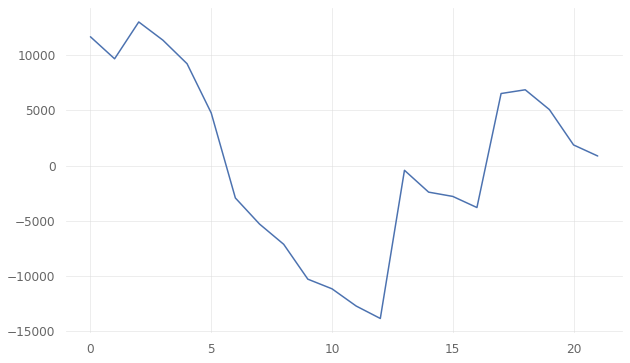

In [78]:
evolucao_patrimonio_compradora = ponta_compradora['Resultado'].cumsum()
evolucao_patrimonio_compradora.plot()

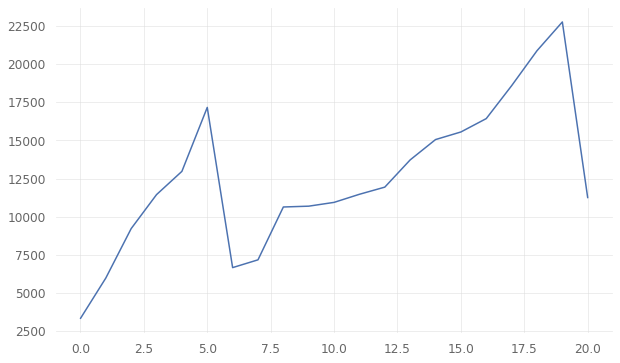

In [79]:
evolucao_patrimonio_vendedora = ponta_vendedora['Resultado'].cumsum()
evolucao_patrimonio_vendedora.plot()

In [116]:
all_trades_FINAL['Resultado_All'] = all_trades_FINAL['Resultado'].sum(1)
all_trades_FINAL

,Entrada_Compra,Saida_Compra,Resultado,Resultado_%,Operação,Entrada_Venda,Saida_Venda,Resultado,Resultado_%,Operação,Resultado_All
0,35510.820312,47180.464844,11669.644531,0.328622,Compra,47180.464844,50522.304688,3341.839844,0.070831,Venda,15011.484375
1,50522.304688,48527.031250,-1995.273438,-0.039493,Compra,48527.031250,51174.117188,2647.085938,0.054549,Venda,651.812500
2,51174.117188,54511.660156,3337.542969,0.065219,Compra,54511.660156,57750.132812,3238.472656,0.059409,Venda,6576.015625
3,57750.132812,56099.914062,-1650.218750,-0.028575,Compra,56099.914062,58326.562500,2226.648438,0.039691,Venda,576.429688
4,58326.562500,56191.585938,-2134.976562,-0.036604,Compra,56191.585938,57714.664062,1523.078125,0.027105,Venda,-611.898438
5,57714.664062,53252.164062,-4462.500000,-0.077320,Compra,53252.164062,57441.308594,4189.144531,0.078666,Venda,-273.355469
6,57441.308594,49735.433594,-7705.875000,-0.134152,Compra,49735.433594,39242.484375,-10492.949219,-0.210975,Venda,-18198.824219
7,39242.484375,36880.156250,-2362.328125,-0.060198,Compra,36880.156250,37389.515625,509.359375,0.013811,Venda,-1852.968750
8,37389.515625,35555.789062,-1833.726562,-0.049044,Compra,35555.789062,39016.968750,3461.179688,0.097345,Venda,1627.453125
9,39016.968750,35854.527344,-3162.441406,-0.081053,Compra,35854.527344,35908.386719,53.859375,0.001502,Venda,-3108.582031


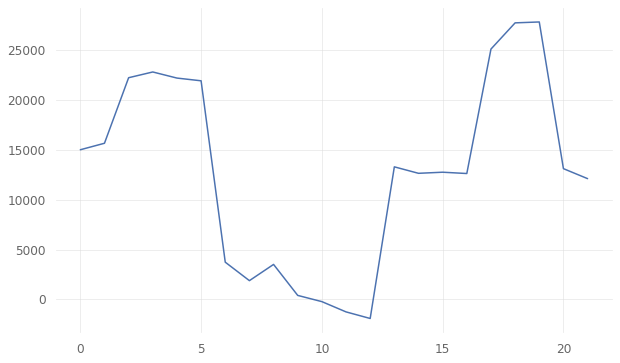

In [117]:
all_trades_FINAL['Resultado_All'].cumsum().plot()

## **7.3. Taxa de Acerto**

Porcentagem de trades com gain. Parâmetro muito comum, mas deve ser complementar. Individualmente não conta muito da história (mesmo ganhando pouco, quando ganhar, ganhar muito!)

In [80]:
results_binning_compradora = np.sign(ponta_compradora['Resultado']).value_counts()
results_binning_compradora

-1.0    17
 1.0     5
Name: Resultado, dtype: int64

In [81]:
Taxa_acerto_compradora = results_binning_compradora[1]/sum(results_binning_compradora)
Taxa_acerto_compradora

0.22727272727272727

In [82]:
results_binning_vendedora = np.sign(ponta_vendedora['Resultado']).value_counts()
results_binning_vendedora

 1.0    19
-1.0     2
Name: Resultado, dtype: int64

In [83]:
Taxa_acerto_vendedora = results_binning_vendedora[1]/sum(results_binning_vendedora)
Taxa_acerto_vendedora

0.9047619047619048

## **7.4. Média de ganhos e perdas**

Complementar ao anterior. Verificar se não está com o viés do apostador (segurar muito no loss e se livrar logo no gain)

In [84]:
ponta_compradora['Result_bin'] = np.sign(ponta_compradora['Resultado'])
pos_neg_medios_compradora = ponta_compradora.groupby('Result_bin').Resultado.mean()
pos_neg_medios_compradora

Result_bin
-1.0   -2249.749311
 1.0    7821.888281
Name: Resultado, dtype: float64

In [87]:
ponta_vendedora['Result_bin'] = np.sign(ponta_vendedora['Resultado'])
pos_neg_medios_vendedora = ponta_vendedora.groupby('Result_bin').Resultado.mean()
pos_neg_medios_vendedora

Result_bin
-1.0   -11003.113281
 1.0     1750.293380
Name: Resultado, dtype: float64

## **7.5. Fator de lucro**

Razão entre os ganhos e as perdas (qts vezes o lucro bruto é maior que a perda bruta?)

In [94]:
ponta_compradora['Result_bin'] = np.sign(ponta_compradora['Resultado'])
pos_neg_results_compradora = ponta_compradora.groupby('Result_bin').Resultado.sum()
pos_neg_results_compradora

Result_bin
-1.0   -38245.738281
 1.0    39109.441406
Name: Resultado, dtype: float64

In [95]:
abs(pos_neg_results_compradora[1]/pos_neg_results_compradora[-1])

1.022582989996128

In [96]:
ponta_vendedora['Result_bin'] = np.sign(ponta_vendedora['Resultado'])
pos_neg_results_vendedora = ponta_vendedora.groupby('Result_bin').Resultado.sum()
pos_neg_results_vendedora

Result_bin
-1.0   -22006.226562
 1.0    33255.574219
Name: Resultado, dtype: float64

In [97]:
abs(pos_neg_results_vendedora[1]/pos_neg_results_vendedora[-1])

1.5111893047315799